In [54]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras.optimizers import Adam
import random
from collections import deque

In [55]:
# Define the environment parameters
MAX_BATTERY_CAPACITY = 100  # Maximum capacity of the battery in kWh
MAX_PRICE = 1.0  # Maximum price of electricity
MAX_DEMAND = 1.0  # Maximum household demand
STATE_SIZE = 3  # Dimension of the state space: price, battery charge, household demand
ACTION_SIZE = 1  # Dimension of the action space: charging rate


We define the DDPGAgent class responsible for our RL agent. In the constructor __init__, we initialize various parameters such as the learning rates for the actor and critic networks, discount factor (gamma), and soft update parameter (tau). We also initialize actor and critic networks along with their target networks

In [56]:
# Define the DDPG agent
class DDPGAgent:
    def __init__(self, state_size, action_size):
        """
        Initialize the DDPG agent with given state and action sizes.
        """
        self.state_size = state_size
        self.action_size = action_size
        self.actor_lr = 0.001
        self.critic_lr = 0.002
        self.gamma = 0.99
        self.tau = 0.001
        
        # Actor model
        self.actor = self.build_actor_model()
        self.target_actor = self.build_actor_model()
        self.actor_optimizer = tf.keras.optimizers.Adam(self.actor_lr)
        
        # Critic model
        self.critic = self.build_critic_model()
        self.target_critic = self.build_critic_model()
        self.critic_optimizer = tf.keras.optimizers.Adam(self.critic_lr)
        
        # Initialize target networks
        self.update_target_networks(tau=1.0)
    
    def build_actor_model(self):
        """
        Build the actor model.
        """
        input_state = Input(shape=(self.state_size,))
        x = Dense(32, activation='relu')(input_state)
        x = Dense(64, activation='relu')(x)
        output_action = Dense(self.action_size, activation='tanh')(x)
        output_action_scaled = tf.keras.layers.Lambda(lambda x: x * MAX_BATTERY_CAPACITY)(output_action)
        model = Model(inputs=input_state, outputs=output_action_scaled)
        return model
    
    def build_critic_model(self):
        """
        Build the critic model.
        """
        input_state = Input(shape=(self.state_size,))
        input_action = Input(shape=(self.action_size,))
        x = concatenate([input_state, input_action])
        x = Dense(32, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        output_q_value = Dense(1)(x)
        model = Model(inputs=[input_state, input_action], outputs=output_q_value)
        return model
    
    def update_target_networks(self, tau):
        """
        Update target networks with a soft update strategy.
        """
        self.update_target(self.target_actor.variables, self.actor.variables, tau)
        self.update_target(self.target_critic.variables, self.critic.variables, tau)
    
    def update_target(self, target_vars, source_vars, tau):
        """
        Perform soft update of target network weights.
        """
        for target_var, source_var in zip(target_vars, source_vars):
            target_var.assign(tau * source_var + (1 - tau) * target_var)
    
    def get_action(self, state):
        """
        Get action from the actor network given a state.
        """
        state = tf.convert_to_tensor(state, dtype=tf.float32)  # Convert state to float32
        return self.actor.predict(state)
    
    def train(self, states, actions, rewards, next_states, dones):
        """
        Train the actor and critic networks using DDPG algorithm.
        """
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)

        # Train critic
        next_actions = self.target_actor.predict(next_states)
        q_values_next = self.target_critic.predict([next_states, next_actions])
        target_q_values = rewards + (1 - dones) * self.gamma * q_values_next
        with tf.GradientTape() as tape:
            q_values = self.critic([states, actions])
            critic_loss = tf.keras.losses.MSE(target_q_values, q_values)
        critic_gradients = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_gradients, self.critic.trainable_variables))
        
        # Train actor
        with tf.GradientTape() as tape:
            predicted_actions = self.actor(states)
            actor_loss = -tf.reduce_mean(self.critic([states, predicted_actions]))
        actor_gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_gradients, self.actor.trainable_variables))
        
        # Update target networks
        self.update_target_networks(self.tau)




In [57]:
# Define the environment
class Environment:
    def __init__(self):
        """
        Initialize the environment with random prices and demands.
        """
        self.current_step = 0
        self.episode_length = 100
        self.prices = np.random.uniform(0, MAX_PRICE, self.episode_length)
        self.demands = np.random.uniform(0, MAX_DEMAND, self.episode_length)
        self.battery_charge = 50  # Initial battery charge, initialized after prices and demands
    
    def reset(self):
        """
        Reset the environment to the initial state.
        """
        self.current_step = 0
        self.battery_charge = 50  # Reset battery charge
        self.prices = np.random.uniform(0, MAX_PRICE, self.episode_length)
        self.demands = np.random.uniform(0, MAX_DEMAND, self.episode_length)
        return np.array([self.prices[self.current_step], self.battery_charge, self.demands[self.current_step]])
    
    def step(self, action):
        """
        Take a step in the environment given an action.
        """
        # Clip action to ensure it's within valid range
        action = np.clip(action, -MAX_BATTERY_CAPACITY, MAX_BATTERY_CAPACITY)
        
        # Update battery charge based on action
        self.battery_charge = np.clip(self.battery_charge + action, 0, MAX_BATTERY_CAPACITY)
        
        # Calculate reward based on electricity price, battery charge, and household demand
        reward = -self.prices[self.current_step] * action + (self.demands[self.current_step] - action)
        
        # Move to next time step
        self.current_step += 1
        
        # Check if episode is done
        done = self.current_step >= self.episode_length
        if done:
            # Reset current step to start a new episode
            self.current_step = 0
        
        # Return next state, reward, done flag, and additional info (not used in this example)
        next_state = np.array([self.prices[self.current_step], self.battery_charge, self.demands[self.current_step]])
        return next_state, reward, done, None




In [58]:
# Main training loop
env = Environment()
agent = DDPGAgent(state_size=STATE_SIZE, action_size=ACTION_SIZE)


In [61]:
# Define new parameters
num_episodes = 100  # Reduce the number of episodes
env.episode_length = 10  # Reduce the episode length
episode_rewards = []

# Main training loop
for episode in range(num_episodes):
    # Training loop for each episode
    state = env.reset()
    total_reward = 0
    
    for _ in range(env.episode_length):
        # Training steps for each time step within an episode
        action = agent.get_action(np.expand_dims(state, axis=0))
        next_state, reward, done, _ = env.step(action)
        agent.train(np.expand_dims(state, axis=0), np.expand_dims(action, axis=0), np.expand_dims(reward, axis=0),
                    np.expand_dims(next_state, axis=0), np.expand_dims(done, axis=0))
        state = next_state
        total_reward += reward
        if done:
            break
    episode_rewards.append(total_reward)
    print("Episode:", episode+1, "Total Reward:", total_reward)


1/1 [==============================] - 0s 61ms/step


/var/folders/j_/mwl680ps3b1czvrppsb_jxgm0000gn/T/ipykernel_28287/3844955773.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  next_state = np.array([self.prices[self.current_step], self.battery_charge, self.demands[self.current_step]])


1/1 [==============================] - 0s 33ms/step
Episode: 1 Total Reward: [[-1506.2466]]
1/1 [==============================] - 0s 32ms/step
Episode: 2 Total Reward: [[-1539.2555]]
1/1 [==============================] - 0s 34ms/step
Episode: 3 Total Reward: [[-1423.0609]]
1/1 [==============================] - 0s 45ms/step
Episode: 4 Total Reward: [[-1265.6788]]
1/1 [==============================] - 0s 29ms/step
Episode: 5 Total Reward: [[-1475.1643]]
1/1 [==============================] - 0s 31ms/step
Episode: 6 Total Reward: [[-1451.2787]]
1/1 [==============================] - 0s 40ms/step
Episode: 7 Total Reward: [[-1429.1266]]
1/1 [==============================] - 0s 36ms/step
Episode: 8 Total Reward: [[-1702.2834]]
1/1 [==============================] - 0s 29ms/step
Episode: 9 Total Reward: [[-1461.3488]]
1/1 [==============================] - 0s 30ms/step
Episode: 10 Total Reward: [[-1364.543]]
1/1 [==============================] - 0s 39ms/step
Episode: 11 Total Reward: [[

In [62]:
import matplotlib.pyplot as plt

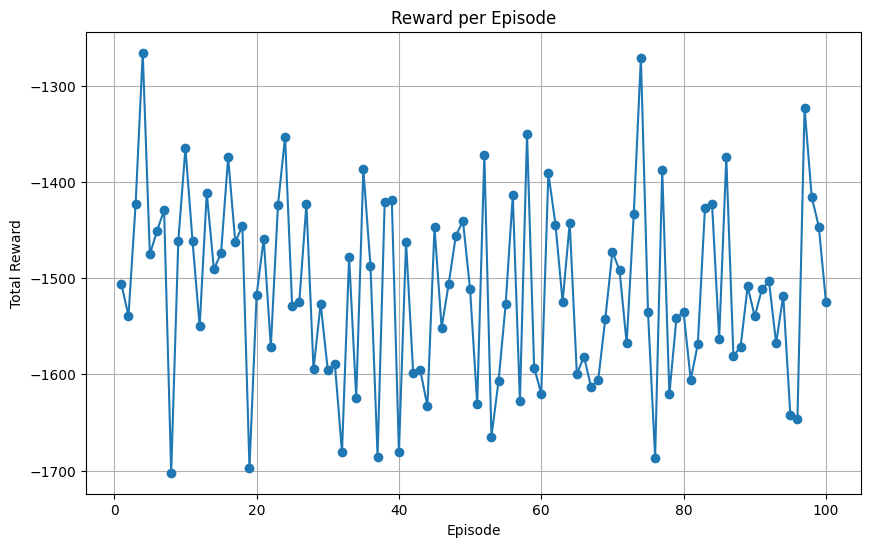

In [68]:
# Reshape episode_rewards if necessary
episode_rewards = np.squeeze(episode_rewards)

# Plot reward per episode
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_episodes+1), episode_rewards, marker='o', linestyle='-')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode')
plt.grid(True)
plt.show()


In [64]:
# Initialize lists to store values
prices = []
battery_charge = []
demands = []

# Initialize environment and state
env = Environment()  # Initialize your environment with appropriate parameters
state = env.reset()  # Reset the environment to get initial state

# Run simulation
num_steps = 100  # Define the number of time steps to simulate
for _ in range(num_steps):
    # Record current state variables
    prices.append(state[0])
    battery_charge.append(state[1])
    demands.append(state[2])
    
    # Use the agent to select an action (you may need to adapt this depending on your agent implementation)
    action = agent.get_action(np.expand_dims(state, axis=0))
    
    # Execute the selected action in the environment
    next_state, _, _, _ = env.step(action)
    
    # Update state for the next time step
    state = next_state

# Plot results
# Code for plotting prices, battery_charge, and demands


1/1 [==============================] - 0s 64ms/step


/var/folders/j_/mwl680ps3b1czvrppsb_jxgm0000gn/T/ipykernel_28287/3844955773.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  next_state = np.array([self.prices[self.current_step], self.battery_charge, self.demands[self.current_step]])


1/1 [==============================] - 0s 41ms/step


/Users/maxfavrot/anaconda3/envs/my_environment/lib/python3.11/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


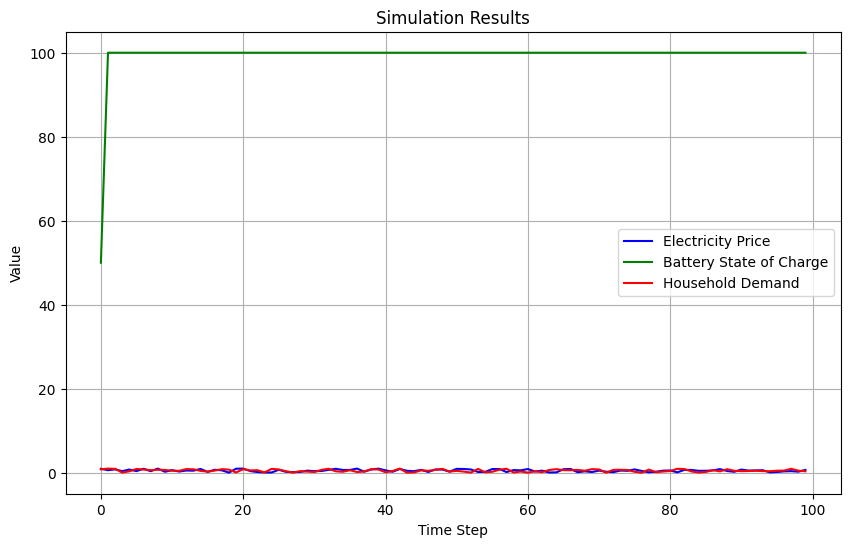

In [65]:
# Plot results
plt.figure(figsize=(10, 6))

# Plot electricity price
plt.plot(range(num_steps), prices, label='Electricity Price', color='blue')

# Plot battery state of charge
plt.plot(range(num_steps), battery_charge, label='Battery State of Charge', color='green')

# Plot household demand
plt.plot(range(num_steps), demands, label='Household Demand', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Simulation Results')
plt.legend()
plt.grid(True)
plt.show()
